In [61]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from consav import linear_interp, linear_interp_1d

import Bargaining as brg

from figures import *

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 14
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
threads = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Plot different cases

In [62]:
font_size = 15
    
# Apply style and font size
plt.style.use('default')  # Use default style (no grid lines)
plt.rcParams.update({'font.size': font_size, 'font.family': 'serif', 'font.serif': 'Times New Roman'})

In [132]:
def plot_surplus_simple(Sw, Sm, grid_power, iP, fix_axes=True, title=None, ax=None):
    # If ax is not provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()
    
    
    ax.plot(grid_power,Sw, label='Woman', color=colors['red'])
    ax.plot(grid_power,Sm, label='Man', color=colors['blue'])
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    
    # Layout
    ax.set_xlabel('Power of member 1, $\mu$')
    ax.set_ylabel('Marital surplus, $s$')
    if title is not None:
        ax.set_title(title)
    # ax.legend()
    
    ax.annotate("Member 1", xy=(grid_power[-1], Sw[-1]), xytext=(grid_power[-1]-0.23, Sw[-1]-0.5), color=colors['red'])
    ax.annotate("Member 2", xy=(grid_power[-1], Sm[-1]), xytext=(grid_power[-1]-0.23, Sm[-1]+0.1), color=colors['blue'])
    
    # Make sure the axis is on the same scale
    if fix_axes:
        ax.set_ylim([-3,3])
        
    ###  Add indifference point annotation
    # find where S crosses x-axis
    interp_power_at_zero_w = linear_interp_1d.interp_1d(Sw, grid_power, 0.0)
    interp_power_at_zero_m = linear_interp_1d.interp_1d(-Sm, grid_power, 0.0)

    # Handle cases where there is no indifference point
    indifference_point_w = True
    indifference_point_m = True
    if interp_power_at_zero_w < 0 or interp_power_at_zero_w > 1:
        interp_power_at_zero_w = 0
        indifference_point_w = False
    if interp_power_at_zero_m < 0 or interp_power_at_zero_m > 1:
        interp_power_at_zero_m = 1
        indifference_point_m = False

        
    # Plot indifference point
    if indifference_point_w:
        ax.plot(interp_power_at_zero_w, 0, marker='o', color=colors['red'], markersize=5)
        ax.annotate("$\\tilde{\mu}_1$", xy=(interp_power_at_zero_w, 0), xytext=(interp_power_at_zero_w, 0.15), color=colors['red'], fontsize=12)
    if indifference_point_m:
        ax.plot(interp_power_at_zero_m, 0, marker='o', color=colors['blue'], markersize=5)
        ax.annotate("$\\tilde{\mu}_2$", xy=(interp_power_at_zero_m, 0), xytext=(interp_power_at_zero_m, 0.15), color=colors['blue'], fontsize=12)
    
    return ax


In [133]:
def plot_power_shift(Sw, Sm, grid_power, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    
    # find where S crosses x-axis
    interp_power_at_zero_w = linear_interp_1d.interp_1d(Sw, grid_power, 0.0)
    interp_power_at_zero_m = linear_interp_1d.interp_1d(-Sm, grid_power, 0.0)

    # Handle cases where there is no indifference point
    indifference_point_w = True
    indifference_point_m = True
    if interp_power_at_zero_w < 0 or interp_power_at_zero_w > 1:
        interp_power_at_zero_w = 0
        indifference_point_w = False
    if interp_power_at_zero_m < 0 or interp_power_at_zero_m > 1:
        interp_power_at_zero_m = 1
        indifference_point_m = False
        
    # Handle divorce case
    divorce = False
    if np.max(Sw)<0 or np.max(Sm)<0:
        divorce = True
    if interp_power_at_zero_m < interp_power_at_zero_w:
        divorce = True
    
    
    # Create grid for plotting
    low_grid = [power for power in grid_power if power < interp_power_at_zero_w]
    middle_grid = [power for power in grid_power if power >= interp_power_at_zero_w and power <= interp_power_at_zero_m]
    high_grid = [power for power in grid_power if power > interp_power_at_zero_m]
    
    # combine grids
    x_grid = np.concatenate((low_grid, [interp_power_at_zero_w], middle_grid, [interp_power_at_zero_m], high_grid))
    y_grid = np.concatenate(([interp_power_at_zero_w]*len(low_grid), [interp_power_at_zero_w], middle_grid, [interp_power_at_zero_m], [interp_power_at_zero_m]*len(high_grid)))

    # Plot
    ax.plot(grid_power,grid_power, color = colors['black'], linewidth = 1.0, linestyle='--')
    
    if divorce==False:
        ax.plot(x_grid, y_grid, color = colors['black'], linewidth = 2.0)
        ax.plot(low_grid, [interp_power_at_zero_w]*len(low_grid), color = colors['red'], linewidth = 3.0)
        ax.plot(high_grid, [interp_power_at_zero_m]*len(high_grid), color = colors['blue'], linewidth = 3.0)
    
        # annotate
        if indifference_point_w:
            ax.annotate("$\\tilde{\mu}_{1}$", xy=(interp_power_at_zero_w, interp_power_at_zero_w), xytext=(interp_power_at_zero_w+0.01, interp_power_at_zero_w-0.03), color=colors['red'])
        if indifference_point_m:
            ax.annotate("$\\tilde{\mu}_{2}$", xy=(interp_power_at_zero_m, interp_power_at_zero_m), xytext=(interp_power_at_zero_m-0.05, interp_power_at_zero_m+0.01), color=colors['blue'])
    
    # Add labels
    ax.set_xlabel('Previous bargaining power, $\mu_{t-1}$')
    ax.set_ylabel('Updated bargaining power, $\mu_t$')
    
    # Make sure the axis is square from 0 to 1
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    return ax
    
    

## Create curves

In [134]:
# generate fictive surplus functions
num_power = 200
grid_power = np.linspace(0, 1, num_power)

def never_happy(grid_power):
    return np.log(0.01+grid_power)/2 + 0.1
def sometimes_happy_high(grid_power):
    return never_happy(grid_power) + 0.7
def sometimes_happy_low(grid_power):
    return never_happy(grid_power) + 0.3
def always_happy(grid_power):
    return never_happy(grid_power) + 2.7


w_never_happy = never_happy(grid_power)
w_always_happy = always_happy(grid_power)
w_sometimes_happy_high = sometimes_happy_high(grid_power)
w_sometimes_happy_low = sometimes_happy_low(grid_power)
power_at_zero_w_high = linear_interp_1d.interp_1d(w_sometimes_happy_high,grid_power, 0.0)

asym = - 0.3
m_never_happy = np.flip(w_never_happy) + asym
m_always_happy = np.flip(w_always_happy) + asym
m_sometimes_happy_high = np.flip(w_sometimes_happy_high) + asym
m_sometimes_happy_low = np.flip(w_sometimes_happy_low) + asym
power_at_zero_m_high = 1-power_at_zero_w_high

<Axes: title={'center': 'E.2: Room for bargaining'}, xlabel='Power of member 1, $\\mu$', ylabel='Marital surplus, $s$'>

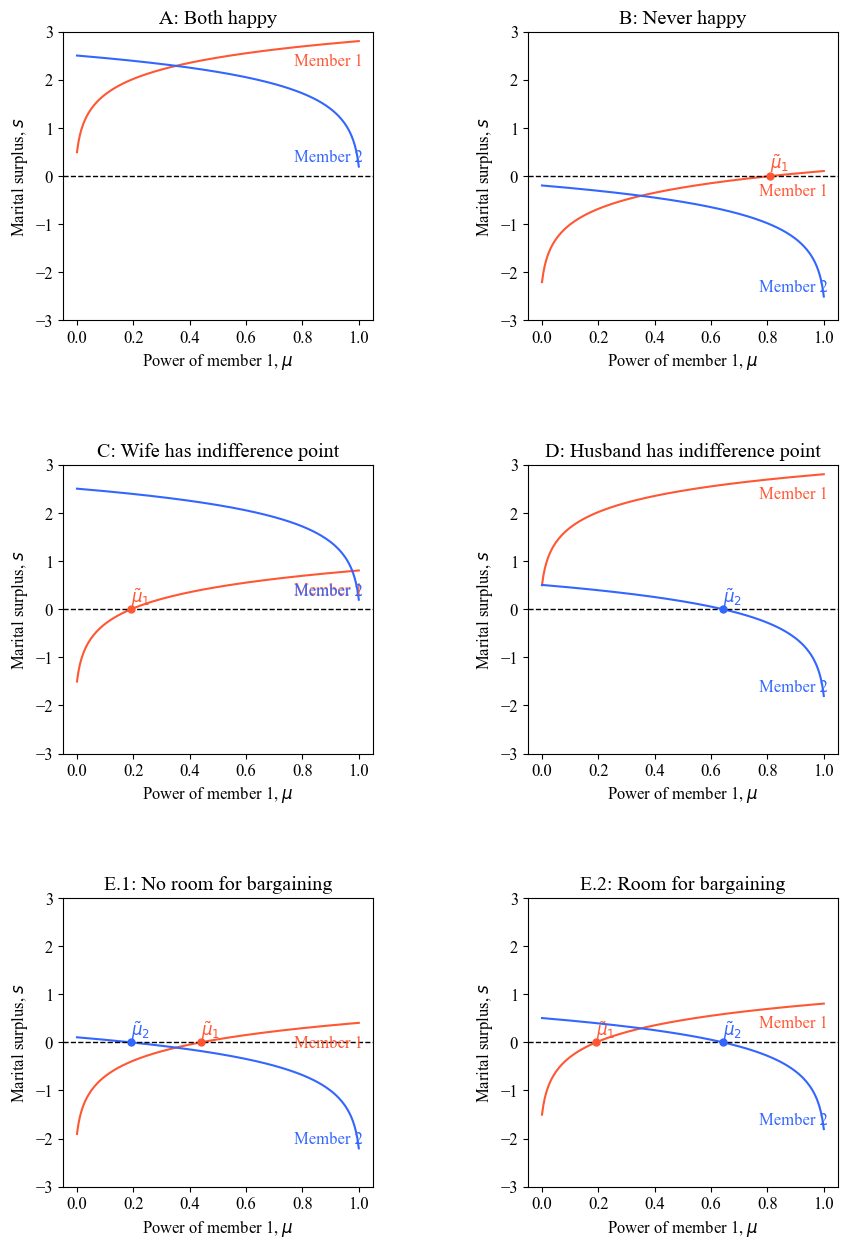

In [135]:
fig, axes = plt.subplots(3,2, figsize=(10,15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

iP = 120

# both happy
plot_surplus_simple(w_always_happy, m_always_happy, grid_power, iP, title='A: Both happy', ax=axes[0][0])

# never happy
plot_surplus_simple(w_never_happy, m_never_happy, grid_power, iP, title='B: Never happy', ax=axes[0][1])

# Wife sometimes happy, husband always happy
plot_surplus_simple(w_sometimes_happy_high, m_always_happy, grid_power, iP, title='C: Wife has indifference point', ax=axes[1][0])

# Wife always happy, husband sometimes happy
plot_surplus_simple(w_always_happy, m_sometimes_happy_high, grid_power, iP, title='D: Husband has indifference point', ax=axes[1][1])

# Both have indifference points, no room for bargaining
plot_surplus_simple(w_sometimes_happy_low, m_sometimes_happy_low, grid_power, iP, title='E.1: No room for bargaining', ax=axes[2][0])

# Both have indifference points, room for bargaining
plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, iP, title='E.2: Room for bargaining', ax=axes[2][1])

## Plot always unhappy

<Axes: xlabel='Power of member 1, $\\mu$', ylabel='Marital surplus, $s$'>

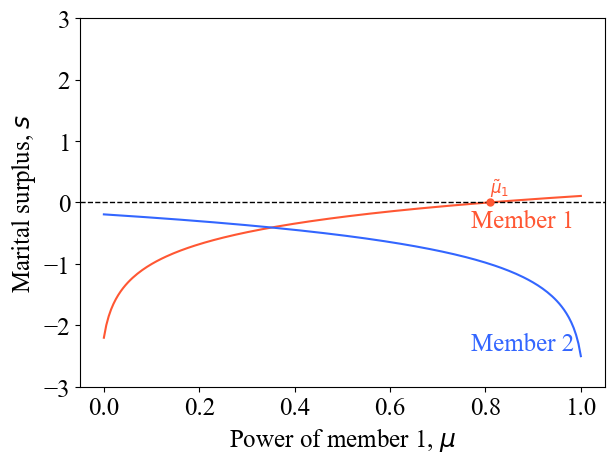

In [136]:
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
plot_surplus_simple(w_never_happy, m_never_happy, grid_power, iP, ax=ax[0])

In [137]:
fig.savefig(path + 'showcase_never_happy.pdf', bbox_inches='tight')

## Plot always happy

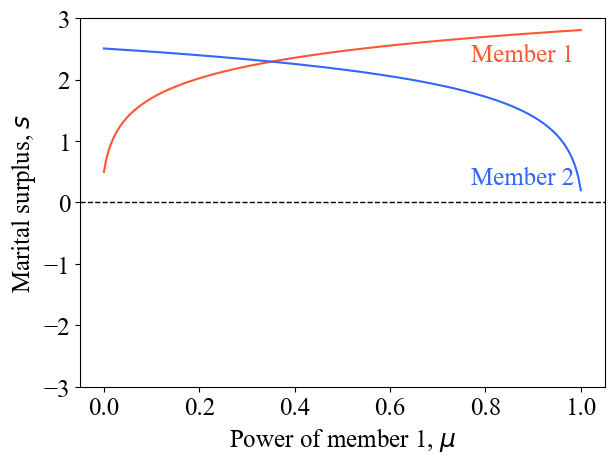

In [142]:
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
ax = plot_surplus_simple(w_always_happy, m_always_happy, grid_power, iP, ax=ax[0])

In [157]:
'Member' in [*ax.texts][0].get_text()

True

In [139]:
fig.savefig(path + 'showcase_always_happy.pdf', bbox_inches='tight')

## No room for bargaining

Text(0.77, -2.1025850929940453, 'Member 2')

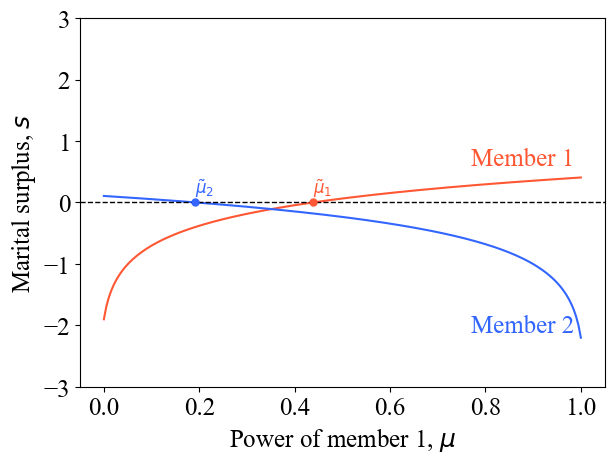

In [158]:
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
ax = plot_surplus_simple(w_sometimes_happy_low, m_sometimes_happy_low, grid_power, iP, ax=ax[0])

# remove annotations from fig
for annotation in ax.texts:
    if 'Member' in annotation.get_text():
        annotation.remove()
ax.annotate("Member 1", xy=(grid_power[-1], w_sometimes_happy_low[-1]), xytext=(grid_power[-1]-0.23, w_sometimes_happy_low[-1]+0.2), color=colors['red'])
ax.annotate("Member 2", xy=(grid_power[-1], m_sometimes_happy_low[-1]), xytext=(grid_power[-1]-0.23, m_sometimes_happy_low[-1]+0.1), color=colors['blue'])

In [115]:
fig.savefig(path + 'showcase_no_bargaining.pdf', bbox_inches='tight')

## Room for bargaining

<Axes: xlabel='Power of member 1, $\\mu$', ylabel='Marital surplus, $s$'>

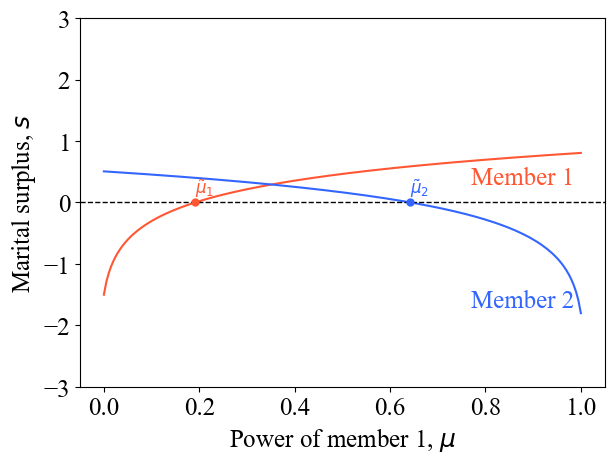

In [116]:
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, iP, ax=ax[0])

In [117]:
fig.savefig(path + 'showcase_bargaining.pdf', bbox_inches='tight')

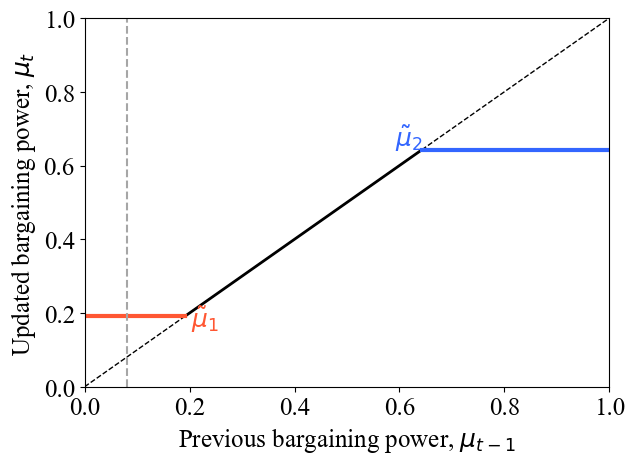

In [118]:
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
ax = plot_power_shift(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, ax=ax[0])

start_power = 0.08
ax.axvline(x=start_power, color=colors['gray'],linestyle='--', label='$\mu_{t-1}$')


In [119]:
fig.savefig(path + 'showcase_power_shift.pdf', bbox_inches='tight')

Text(0.20190601707843786, -3.2, '$\\mu_t$')

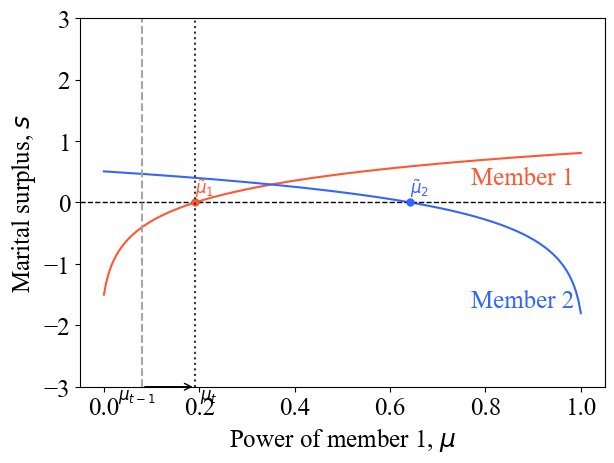

In [120]:
fig, ax = make_fig(num_plots=1,dimensions=(1,1))
ax = plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, iP, ax=ax[0])

ax.axvline(x=start_power, color=colors['gray'],linestyle='--', label='$\mu_{t-1}$')
ax.axvline(x=power_at_zero_w_high, color=colors['gray_dark'],linestyle=':', label='$\mu_{t}$')

font_size = 12
plt.style.use('default')  # Use default style (no grid lines)
plt.rcParams.update({'font.size': font_size, 'font.family': 'serif', 'font.serif': 'Times New Roman'})
ax.annotate("", xy=(power_at_zero_w_high, -3), xytext=(start_power, -3), arrowprops=dict(arrowstyle="->"))
ax.annotate("$\mu_{t-1}$", xy=(start_power, -3), xytext=(start_power-0.05, -3.2))
ax.annotate("$\mu_t$", xy=(power_at_zero_w_high, -3), xytext=(power_at_zero_w_high+0.01, -3.2))

In [121]:
fig.savefig(path + 'showcase_bargaining_power_shift.pdf', bbox_inches='tight')

## Illustrate interpolation

In [163]:
interp_power_at_zero_w = linear_interp_1d.interp_1d(w_sometimes_happy_high, grid_power, 0.0)
interp_power_at_zero_m = linear_interp_1d.interp_1d(-m_sometimes_happy_high, grid_power, 0.0)

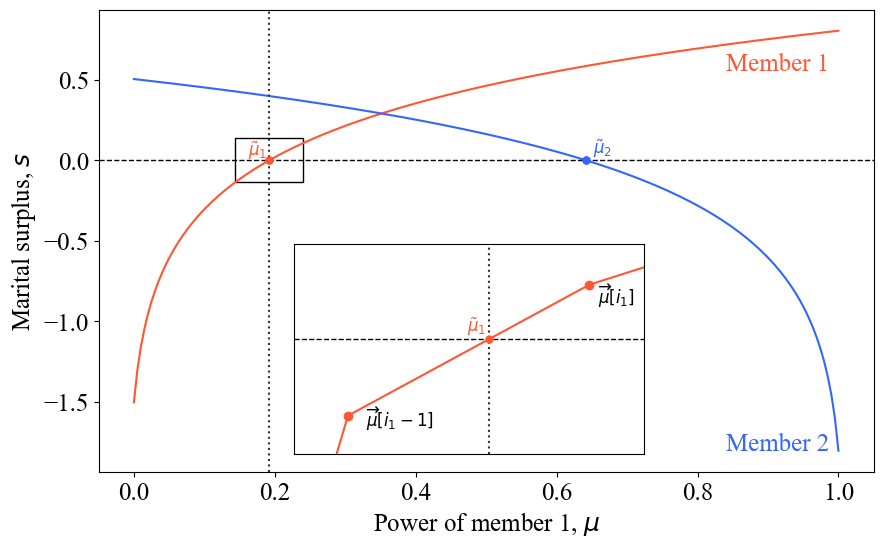

In [182]:
# User settings
iP = 5

# Layout
font_size = 18
plt.style.use('default')  # Use default style (no grid lines)
plt.rcParams.update({'font.size': font_size, 'font.family': 'serif', 'font.serif': 'Times New Roman'})

# Make coarse grid
coarse_grid_power = np.linspace(power_at_zero_w_high-0.2, power_at_zero_w_high+0.2, 4)
coarse_w_sometimes_happy_high = sometimes_happy_high(coarse_grid_power)
if np.isnan(coarse_w_sometimes_happy_high[0]):
    coarse_w_sometimes_happy_high[0] = w_sometimes_happy_high[0]
    coarse_grid_power[0] = grid_power[0]

# make a plot
fig, ax = plt.subplots(figsize=(10,6))
plot_surplus_simple(w_sometimes_happy_high, m_sometimes_happy_high, grid_power, iP, fix_axes=False, ax=ax)

# Legends / Annotations
# ax.legend(loc='upper right')
ax.axvline(x=power_at_zero_w_high, color=colors['gray_dark'],linestyle=':', label='$\mu_{t}$')

# Replace annotations
# remove annotations from fig
for annotation in ax.texts:
    annotation.remove()
ax.annotate("Member 1", xy=(grid_power[-1], w_sometimes_happy_high[-1]), xytext=(grid_power[-1]-0.16, w_sometimes_happy_high[-1]-0.25), color=colors['red'])
ax.annotate("Member 2", xy=(grid_power[-1], m_sometimes_happy_high[-1]), xytext=(grid_power[-1]-0.16, m_sometimes_happy_high[-1]+0.00), color=colors['blue'])

ax.plot(interp_power_at_zero_w, 0, marker='o', color=colors['red'], markersize=5)
ax.annotate("$\\tilde{\mu}_1$", xy=(interp_power_at_zero_w, 0), xytext=(interp_power_at_zero_w-0.03, 0.03), color=colors['red'], fontsize=12)
ax.plot(interp_power_at_zero_m, 0, marker='o', color=colors['blue'], markersize=5)
ax.annotate("$\\tilde{\mu}_2$", xy=(interp_power_at_zero_m, 0), xytext=(interp_power_at_zero_m+0.01, 0.04), color=colors['blue'], fontsize=12)

# ZOOM PLOT - make an overlaying plot that focues on the vertical line at power_at_zero_w_high and place in the bottom right corner
# Location of the overlaying plot

min_x = coarse_grid_power[1]-0.03
max_x = coarse_grid_power[2]+0.03
x_range = max_x-min_x

min_y = -0.3
max_y = 0.25
y_range = max_y-min_y

left, bottom, width, height = [0.32, 0.14, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height]) # [left, bottom, width, height]

# Convert coordinates from graph to plot
ax2_x = (power_at_zero_w_high-min_x)/x_range
ax2_y = (0.0-min_y)/y_range

# get length of X axis in ax
x_axis_length = ax.get_xlim()[1]-ax.get_xlim()[0]
y_axis_length = ax.get_ylim()[1]-ax.get_ylim()[0]
left_coord = ax.get_xlim()[0] + left * x_axis_length
bottom_coord = ax.get_ylim()[0] + bottom * y_axis_length


# Make plot
ax2.scatter(coarse_grid_power, coarse_w_sometimes_happy_high, color=colors['red'])
ax2.plot(coarse_grid_power, coarse_w_sometimes_happy_high, color=colors['red'], label='Interpolated surplus')

# Interpolated point
ax2.axhline(y=0, color='black',linestyle='--', linewidth=1.0)
interp_power_at_zero = linear_interp_1d.interp_1d(coarse_w_sometimes_happy_high, coarse_grid_power, 0.0)
# ax2.scatter(interp_power_at_zero, 0.0, color=colors['red'], marker='s', s=50, linewidth=2)

# make a box around the selected area in ax
rect = matplotlib.patches.Rectangle((min_x+0.25*x_range,min_y+0.3*y_range),x_range*0.5,y_range*0.5,linewidth=1,edgecolor='black',facecolor='none')
ax.add_patch(rect)
#True surplus
# ax2.plot(grid_power, w_sometimes_happy_high, color=colors['red'], alpha=0.5, label='True surplus')
# ax2.scatter(power_at_zero_w_high, 0.0, color=colors['red'], marker='x', s=100, linewidth=2)


# remove all labels and titles from ax2
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])

# adjust limits of ax2
ax2.set_xlim([min_x, max_x])
ax2.set_ylim([min_y,max_y])

# Labels and annotations
# place the legend for ax2 to the right of ax2
# ax2.legend(loc='center left', bbox_to_anchor=(-0.0, 0.85), frameon=False)
ax2.axvline(x=interp_power_at_zero, color=colors['gray_dark'],linestyle=':', label='')

ax2.annotate('$\overrightarrow{\mu}[i_1-1]$', xy=(coarse_grid_power[1], coarse_w_sometimes_happy_high[1]), xytext=(coarse_grid_power[1]+0.01, coarse_w_sometimes_happy_high[1]-0.03), fontsize=12)
ax2.annotate('$\overrightarrow{\mu}[i_1]$', xy=(coarse_grid_power[2], coarse_w_sometimes_happy_high[2]), xytext=(coarse_grid_power[2]+0.005, coarse_w_sometimes_happy_high[2]-0.05), fontsize=12)
# ax2.annotate('$\mu_{1}$', xy=(power_at_zero_w_high, 0), xytext=(power_at_zero_w_high-0.012, +0.08))
ax2.annotate('$\\tilde{\mu}_{1}$', xy=(interp_power_at_zero, 0), xytext=(interp_power_at_zero-0.012, +0.02), color=colors['red'], fontsize=12)
ax2.plot(interp_power_at_zero, 0, marker='o', color=colors['red'], markersize=5)

# get coordinates of the box in ax2
box = rect.get_bbox()
box_points = box.get_points()
box_x = box_points[0][0]
box_y = box_points[0][1]
box_width = box_points[1][0]-box_points[0][0]
box_height = box_points[1][1]-box_points[0][1]

In [130]:
fig.savefig(path + 'showcase_interpolation.pdf', bbox_inches='tight')